# Bus Simulator Sandbox
## Yuwen Chang

In [1]:
# import packages
from __future__ import print_function, division
from IPython.display import display, clear_output

import os
import sys
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import calendar
from datetime import datetime

import collections
from collections import defaultdict

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Yuwen/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# I. Data Generation Pipeline
## 1. Vehicle Data
## 1a. Real-time Data Query

In [2]:
from fetchbus import bus_data, plot_tsd

In [3]:
# !python fetchbus.py $MTAAPIKEY "M1" 240
df = bus_data(os.getenv("MTAAPIKEY"), "M1", 1)


Time Elapsed: 0.0 min(s)
Bus Line: M1
Number of Active Buses: 7
Error: <class 'KeyError'>
Bus 2 (#MTA NYCT_6789) is at latitude 40.816541 and longitude -73.938713
Bus 3 (#MTA NYCT_3833) is at latitude 40.732188 and longitude -73.990164
Bus 4 (#MTA NYCT_6777) is at latitude 40.820962 and longitude -73.935847
Bus 5 (#MTA NYCT_3888) is at latitude 40.719843 and longitude -73.998646
Bus 6 (#MTA NYCT_6775) is at latitude 40.775306 and longitude -73.964955
Bus 7 (#MTA NYCT_3892) is at latitude 40.77254 and longitude -73.964879

Time Elapsed: 0.5 min(s)
Bus Line: M1
Number of Active Buses: 7
Error: <class 'KeyError'>
Bus 2 (#MTA NYCT_6775) is at latitude 40.774404 and longitude -73.965611
Bus 3 (#MTA NYCT_3892) is at latitude 40.773641 and longitude -73.964078
Bus 4 (#MTA NYCT_3888) is at latitude 40.720248 and longitude -73.998126
Bus 5 (#MTA NYCT_3833) is at latitude 40.735227 and longitude -73.990019
Bus 6 (#MTA NYCT_6777) is at latitude 40.820962 and longitude -73.935847
Bus 7 (#MTA NYCT

## 1b. Historical Sample Data

In [4]:
df = pd.read_csv("MTA_data/M1-Tue-180410-154415-260.csv")
df = df[df['DirectionRef'] == 1]
df['VehDistAlongRoute'] = df['CallDistanceAlongRoute'] - df['DistanceFromCall']
df['RecordedAtTime'] = pd.to_datetime(df['RecordedAtTime'])

mod = list(df['Unnamed: 0'])
tiempo = 0
ts = []
for i,v in enumerate(mod[:-1]):
    ts.append(tiempo)
    if mod[i+1] < mod[i]:
        tiempo += 30
    else:
        continue
ts.append(ts[-1])
df['ts'] = ts

df.head()

,Unnamed: 0,Bearing,BlockRef,CallDistanceAlongRoute,DataFrameRef,DatedVehicleJourneyRef,DestinationName,DestinationRef,DirectionRef,DistanceFromCall,...,ProgressStatus,PublishedLineName,RecordedAtTime,StopPointName,StopPointRef,StopsFromCall,VehicleRef,VisitNumber,VehDistAlongRoute,ts
1,1,233.31764,MTA NYCT_OF_B8-Weekday-SDon_E_OF_52620_M7-205,7653.54,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-088000_M7_205,E VILLAGE 8 ST via 5 AV,MTA_403793,1,0.00,...,NaN,M1,2018-04-10 19:44:02,5 AV/W 59 ST,MTA_400512,0,MTA NYCT_6764,1,7653.54,0
2,2,49.23225,MTA NYCT_OF_B8-Weekday-SDon_E_OF_50340_M1-139,13730.36,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-084200_M1_139,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,6.76,...,layover,M1,2018-04-10 19:44:10,CENTRE ST/BROOME ST,MTA_803192,0,MTA NYCT_6748,1,13723.60,0
3,3,233.78738,MTA NYCT_OF_B8-Weekday-SDon_E_OF_55860_M1-149,1270.21,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-093400_M1_149,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,9.06,...,NaN,M1,2018-04-10 19:43:47,5 AV/W 135 ST,MTA_400094,0,MTA NYCT_6759,1,1261.15,0
4,4,234.06093,MTA NYCT_OF_B8-Weekday-SDon_E_OF_51900_M1-141,9963.37,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-086800_M1_141,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,14.94,...,NaN,M1,2018-04-10 19:43:45,5 AV/W 31 ST,MTA_400325,0,MTA NYCT_6773,1,9948.43,0
6,6,233.75938,MTA NYCT_OF_B8-Weekday-SDon_E_OF_29580_M1-123,4506.30,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-091900_M1_147,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,21.44,...,NaN,M1,2018-04-10 19:43:55,5 AV/EAST 98 ST,MTA_404081,0,MTA NYCT_6778,1,4484.86,0


In [5]:
df.columns

Index(['Unnamed: 0', 'Bearing', 'BlockRef', 'CallDistanceAlongRoute',
       'DataFrameRef', 'DatedVehicleJourneyRef', 'DestinationName',
       'DestinationRef', 'DirectionRef', 'DistanceFromCall',
       'ExpectedArrivalTime', 'ExpectedDepartureTime', 'JourneyPatternRef',
       'Latitude', 'LineRef', 'Longitude', 'Monitored', 'OperatorRef',
       'OriginAimedDepartureTime', 'OriginRef', 'PresentableDistance',
       'ProgressRate', 'ProgressStatus', 'PublishedLineName', 'RecordedAtTime',
       'StopPointName', 'StopPointRef', 'StopsFromCall', 'VehicleRef',
       'VisitNumber', 'VehDistAlongRoute', 'ts'],
      dtype='object')

## 2. Route Data
- METHOD 1: Subset and sort built-in data using CallDistanceAlongRoute in df
- METHOD 2: Query latest GTFS data through online database
- METHOD 3: Use up-to-date shapefile, read as gpd and query

## 2a. CallDistanceAlongRoute
Caveat: only available when there is at least one complete run in the data (can be combined by several buses)

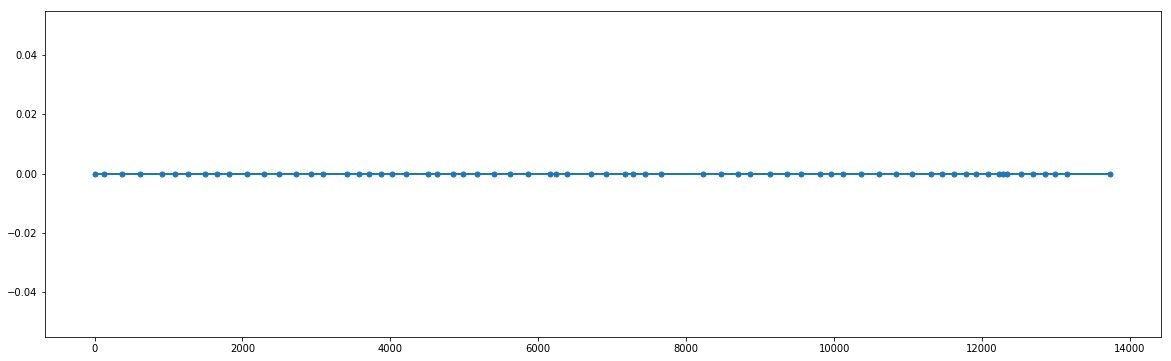

In [6]:
stops_x = df['CallDistanceAlongRoute'].unique()
stops_y = [0] * len(stops_x)

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.plot(stops_x, stops_y, 'o-', markersize=5)

## 2b. Query from GTFS Data
Caveat: multiple routes and shapes for a bus line

In [7]:
# import with py 2 and py 3 compatibility
try:
    import urllib2
    from urllib2 import HTTPError
    from urllib2 import urlopen
    from urllib import urlencode
    from StringIO import StringIO as io

except ImportError:
    import urllib
    from urllib.error import HTTPError
    from urllib.request import urlopen, Request
    from urllib.parse import urlencode
    from io import BytesIO as io

import ast

In [8]:
import fiona
import geopandas as gpd
from shapely.geometry import Point

In [9]:
# set SQL source
SQL_SOURCE = 'https://ywc249.carto.com/api/v2/sql?q='

# define query function
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """
    Queries carto datasets from a given carto account
    
    ARGUMENTS
    ----------
    query: a valid sql query string
    format: outlut format (default: CSV)
    source: a valid sql api endpoint OPTIONAL (default: Carto ywc249 account)

    RETURN
    ----------
    - the return of the sql query AS A STRING
    
    NOTES
    ----------
    designed for the carto API, tested only with CSV return format
    """
    
    data = urlencode({'format':format, 'q':query}).encode('utf-8')
    try:
        response = urlopen(source, data)
    except HTTPError as e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return response.read()

In [10]:
df['DatedVehicleJourneyRef'].unique()
df['DatedVehicleJourneyRef'].value_counts().idxmax()[9:]

'OF_B8-Weekday-SDon-095400_M1_154'

In [11]:
# make query for a given route
# the shape.txt files are pre-uploaded to my Carto space as csv files

route = df['PublishedLineName'].unique()[0]
boro = route[0].lower() # make query from respecttive GTFS shape csv
trip_id = df['DatedVehicleJourneyRef'].value_counts().idxmax()[9:]

q_shape = '''
SELECT *
FROM shapes_{0}
WHERE shape_id = (
  SELECT shape_id
  FROM trips_{0}
  WHERE trip_id = '{1}')
ORDER BY shape_pt_sequence
'''.format(boro, trip_id)

q_stop = '''
query stops shapefile here
'''

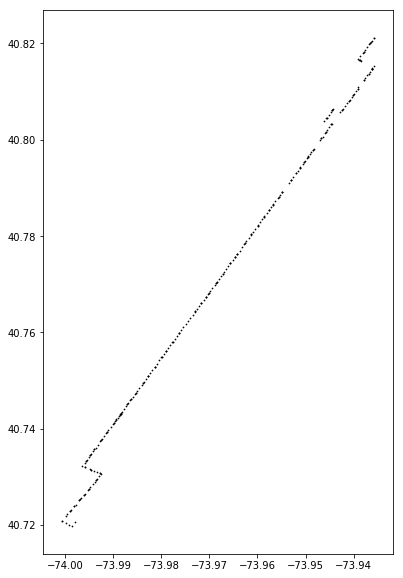

In [12]:
r_shape = pd.read_csv(io(queryCartoDB(q_shape)), sep=',')
r_shape['geometry'] = [Point(r_shape.iloc[i,5], r_shape.iloc[i,4]) for i in range(len(r_shape))]
shape_gdf = gpd.GeoDataFrame(r_shape)
shape_gdf.plot(facecolor='r', edgecolor='k', markersize=0.5, figsize=(10,10))

## 2c. Shapefile
Caveat: currently, I haven't found a good source that provides official or reliable constant update, but if there is one, this one is probably the easiest way

## 3. Visualization
## 3a. Plain Line
### Issue: dynamic update controller

In [13]:
# import osmnx as ox
# import networkx as nx
# import geopandas as gpd
# from collections import Counter

# from geopy import Nominatim
from geopy.distance import vincenty
# from shapely.geometry import Point

### Issue: precision
1. Use distance along the route (geopy, Google API, or Carto API)
2. Preferably, find SIRI data that contains variable "CallDistanceAlongRoute"
3. Check visualization directions

In [55]:
df3.sort_values(['VehDistAlongRoute'], inplace=True)

# mark vehicles that are bunching 
spacing = np.diff(df3['VehDistAlongRoute'])
bunch = spacing < 100 # set threshold (meters) to be identified as BB
bunch_a = np.array([False] + list(bunch))
bunch_b = np.array(list(bunch) + [False])
bunch = bunch_a + bunch_b

/Users/Yuwen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


18

In [57]:
df3[bunch]

,Unnamed: 0,Bearing,BlockRef,CallDistanceAlongRoute,DataFrameRef,DatedVehicleJourneyRef,DestinationName,DestinationRef,DirectionRef,DistanceFromCall,...,ProgressStatus,PublishedLineName,RecordedAtTime,StopPointName,StopPointRef,StopsFromCall,VehicleRef,VisitNumber,VehDistAlongRoute,ts
3673,14,49.23225,MTA NYCT_OF_B8-Weekday-SDon_E_OF_20820_M1-105,13730.36,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-089200_M1_140,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,92.43,...,layover,M1,2018-04-10 20:44:21,CENTRE ST/BROOME ST,MTA_803192,0,MTA NYCT_3832,1,13637.93,3540
3665,6,49.23225,MTA NYCT_OF_B8-Weekday-SDon_E_OF_18120_M1-102,13730.36,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-088600_M7_225,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,11.27,...,layover,M1,2018-04-10 20:44:37,CENTRE ST/BROOME ST,MTA_803192,0,MTA NYCT_6750,1,13719.09,3540


KeyboardInterrupt: 

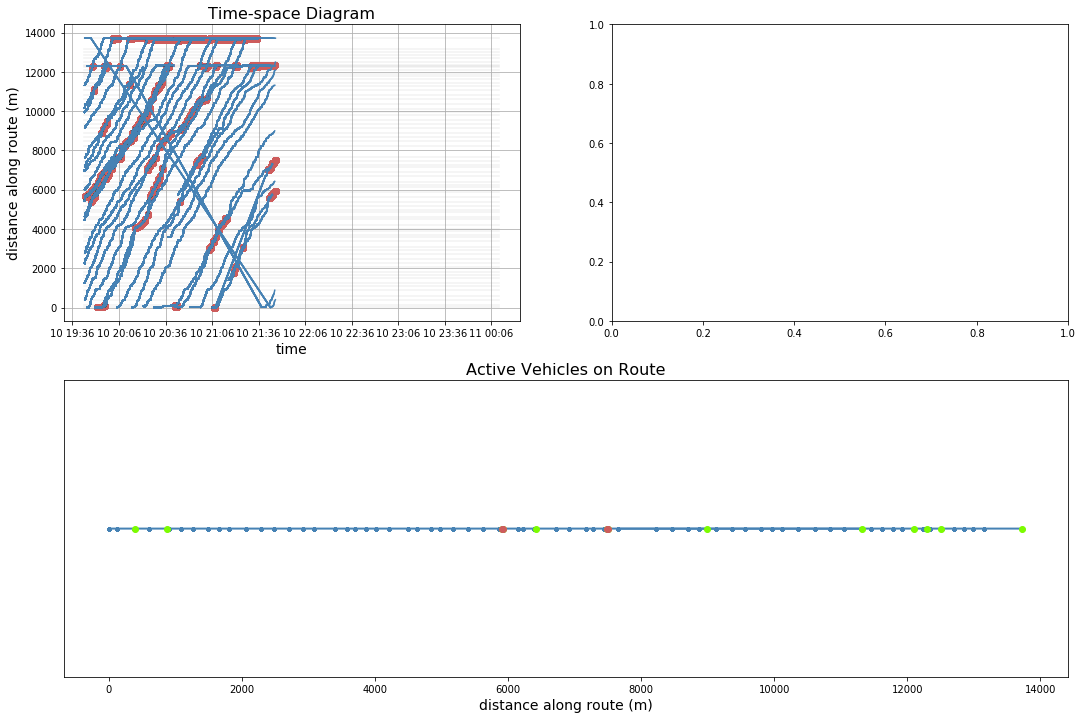

In [59]:
time_coef = 100

# plot figure
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)


# plot CallDistanceAlongRoute (bus stops)
[ax1.plot([df['RecordedAtTime'].min(), df['RecordedAtTime'].max()], [i, i], color='gray', alpha=0.1) for i in df['CallDistanceAlongRoute'].unique()]
p1, = ax1.plot([], [], '-', color='steelblue')

ax1.grid()
ax1.set_xlabel("time", fontsize=14)
ax1.set_ylabel("distance along route (m)", fontsize=14)
ax1.set_title("Time-space Diagram", fontsize=16)



# plot dynamic route line topology
ax3.plot(df['CallDistanceAlongRoute'], [0]*len(df), '.-', color='steelblue')
p3, = ax3.plot([], [], 'o', color='lawngreen')
p4, = ax3.plot([], [], 'o', color='indianred')

ax3.set_yticks([])
ax3.set_xlabel("distance along route (m)", fontsize=14)
ax3.set_title("Active Vehicles on Route", fontsize=16)



for i in range(0,df['ts'].max(),30):
    df3 = df[df['ts'] == i]
    df1 = df[df['ts'] <= i]
    
    # mark vehicles that are bunching 
    df3.sort_values(['VehDistAlongRoute'], inplace=True)
    spacing = np.diff(df3['VehDistAlongRoute'])
    bunch = spacing < 100 # set threshold (meters) to be identified as BB
    bunch_a = np.array([False] + list(bunch))
    bunch_b = np.array(list(bunch) + [False])
    bunch = bunch_a + bunch_b
    bb_df = df3[bunch]
    
    # plot TSD for each vehicle
    for i, v in enumerate(df1['VehicleRef'].unique()):
        # subset data for single vehicle
        veh_df = df1[df1['VehicleRef'] == v]
        ax1.plot(veh_df['RecordedAtTime'], veh_df['VehDistAlongRoute'], '-', color='steelblue', alpha=0.5)
        ax1.plot(bb_df['RecordedAtTime'], bb_df['VehDistAlongRoute'], 'o', color='indianred', alpha=0.5)
        #ax1.annotate('%s'%v.split("_")[1], (list(veh_df['RecordedAtTime'])[0],list(veh_df['VehDistAlongRoute'])[0]))
        
    p3.set_data(df3['VehDistAlongRoute'], [0]*len(df3))
    p4.set_data(bb_df['VehDistAlongRoute'], [0]*len(bb_df))
    clear_output(wait=True)
    display(fig)
    time.sleep(1/time_coef)
# plt.tight_layout()
# plt.show()

KeyboardInterrupt: 

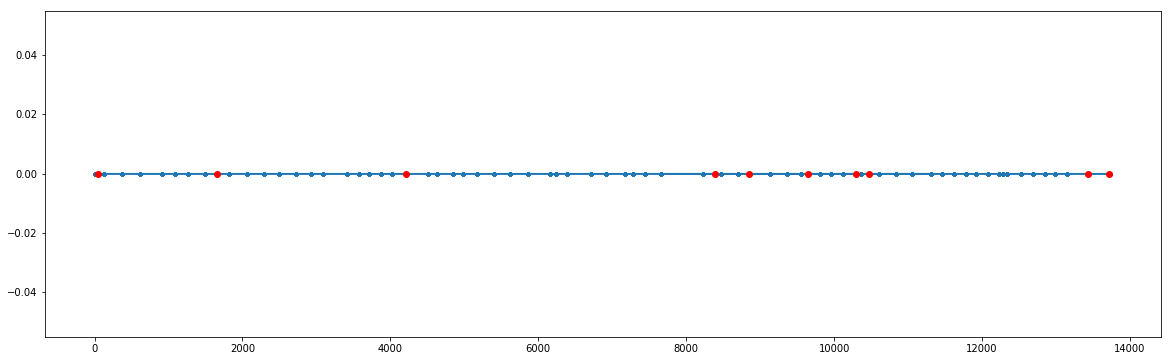

In [58]:
time_coef = 10
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.plot(df['CallDistanceAlongRoute'], [0]*len(df), '.-')
p, = ax.plot([], [], 'ro')

for i in range(0,df['ts'].max(),30):
    df2 = df[df['ts'] == i]
    p.set_data(df2['VehDistAlongRoute'], [0]*len(df2))
    clear_output(wait=True)
    display(fig)
    time.sleep(1/time_coef)

## 3b. Plain Topology

## 3c. Map Topology

In [ ]:
import gmap

## 3d. Time-space Diagram
Also include a log file!

## 4. Simulation
## 4a. Objects Creation

## 4b. Attribute Assignment

## 4c. Environment Variables

## 4d. User Interface

## 4e. Dynamic Display
1. 0.5-sec update
2. time-space diagram
3. trace log

## 4f. Web Deployment
1. Control panel
2. Real-time info on Google basemap
3. Real-time info on straightened route topology
    - 3a. BB indicator
4. Dynamic time-space diagram

# End

- 3/11 4
- 3/12 1.5
- 3/16 1
- 3/17 2
- 3/18 2
- 3/20 1.5
- 3/23 2
- 4/3 3
- 4/5 0.5
- 4/6 1.5
- 4/9 1.5
- 4/21 9
- 4/22 9

In [46]:
# calculate stop distances
dist = []
lats = list(B54_merge['stop_lat'])
lons = list(B54_merge['stop_lon'])
for i in arange(len(B54_stops)):
    if i < len(B54_stops) - 1:
        p1 = lats[i], lons[i]
        p2 = lats[i+1], lons[i+1]
        di = vincenty(p1, p2).meters
        dist.append(di)
dist

[164.10592592573394,
 524.6821220855292,
 183.2864635647531,
 166.04481363027242,
 168.16662072005468,
 249.32389728515443,
 280.8678932398275,
 65.1613773786362,
 162.277246106055,
 160.8227222138864,
 156.99423276306914,
 177.8182272706027,
 262.3958689692586,
 186.7201549309188,
 134.44950499065496,
 113.44836241741916,
 271.7303956584878,
 243.00538513176005,
 292.5054493596941,
 190.84614888127206,
 295.74318979161654,
 180.16350288585392,
 297.9947729558094,
 205.45446314960742,
 168.5189134674809,
 151.1404164049675,
 170.5531370778554,
 218.34221496184352,
 226.21779839123397,
 226.0960471262775,
 374.39793393469455,
 130.71672370770722]

In [51]:
# calculate stop distances along the route (cumulative distance)
di = 0
cum_dist = [0]
for d in dist[:-1]:
    di += d
    cum_dist.append(di)
cum_dist = np.array(cum_dist)
cum_dist

array([   0.        ,  164.10592593,  688.78804801,  872.07451158,
       1038.11932521, 1206.28594593, 1455.60984321, 1736.47773645,
       1801.63911383, 1963.91635994, 2124.73908215, 2281.73331491,
       2459.55154218, 2721.94741115, 2908.66756608, 3043.11707107,
       3156.56543349, 3428.29582915, 3671.30121428, 3963.80666364,
       4154.65281252, 4450.39600231, 4630.5595052 , 4928.55427816,
       5134.00874131, 5302.52765477, 5453.66807118, 5624.22120826,
       5842.56342322, 6068.78122161, 6294.87726874, 6669.27520267])

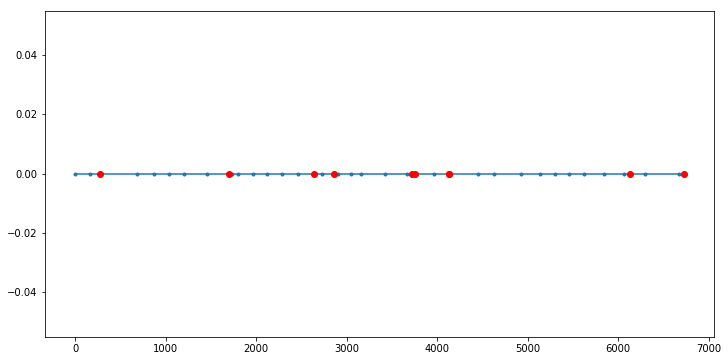

In [63]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(cum_dist, [0]*len(cum_dist), '.-')
ax.plot(df['VehDistAlongRoute'], [0]*len(df), 'ro')
plt.show()

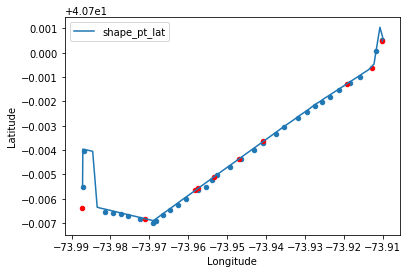

In [64]:
# plot route
ax = temp_shp.plot('shape_pt_lon', 'shape_pt_lat')

# plot stops
B54_stops.plot.scatter('stop_lon', 'stop_lat', ax=ax)

# plot active buses
df.plot.scatter('Longitude', 'Latitude', color='red', ax=ax)